# TP OpenMP - October 2022
## Part 1 : Pi
### Compilation

#### Cleaning

In [7]:
!rm tp_openmp_part_1_pi_impl_critical
!rm tp_openmp_part_1_pi_impl_atomic
!rm tp_openmp_part_1_pi_impl_reduce
!rm tp_openmp_part_1_pi_impl_split

##### Compiling

In [6]:
!g++ -o tp_openmp_part_1_pi_impl_reduce tp_openmp_part_1_pi_impl_reduce.cpp -fopenmp -O3 -march=native
!g++ -o tp_openmp_part_1_pi_impl_atomic tp_openmp_part_1_pi_impl_atomic.cpp -fopenmp -O3 -march=native
!g++ -o tp_openmp_part_1_pi_impl_critical tp_openmp_part_1_pi_impl_critical.cpp -fopenmp -O3 -march=native
!g++ -o tp_openmp_part_1_pi_impl_split tp_openmp_part_1_pi_impl_split.cpp -fopenmp -O3 -march=native

### Performance evaluation

In [3]:
import os
import subprocess
import csv
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

try:
    os.remove("pi_stats.csv")
except OSError:
    pass

# Creating the output csv file
with open("pi_stats.csv", "w") as stat_file:
    writer = csv.writer(stat_file)

num_steps = [10000, 1000000, 100000000]#, 1000000000000]
nb_core = [1, 2, 4, 8]
repeats = range(0,10)

for nsteps in num_steps:
    for ncore in nb_core:
        for repeat in repeats:
            args = ("./tp_openmp_part_1_pi_impl_reduce", "-C", str(ncore), "-N", str(nsteps))
            popen = subprocess.Popen(args, stdout=subprocess.PIPE)
            popen.wait()

            args = ("./tp_openmp_part_1_pi_impl_atomic", "-C", str(ncore), "-N", str(nsteps))
            popen = subprocess.Popen(args, stdout=subprocess.PIPE)
            popen.wait()

            args = ("./tp_openmp_part_1_pi_impl_critical", "-C", str(ncore), "-N", str(nsteps))
            popen = subprocess.Popen(args, stdout=subprocess.PIPE)
            popen.wait()

            args = ("./tp_openmp_part_1_pi_impl_split", "-C", str(ncore), "-N", str(nsteps))
            popen = subprocess.Popen(args, stdout=subprocess.PIPE)
            popen.wait()





### Performance analysis
#### Weak scaling

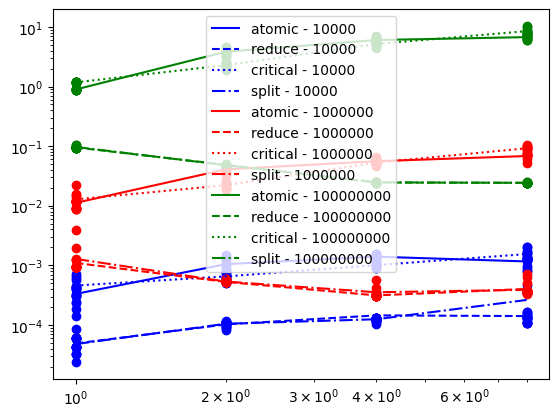

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt

import pandas as pd

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('pi_stats.csv',header=None,names=['version','nbcore','num_steps','runtime'],dtype={
                     'version': str,
                     'nbcore': int,
                     'num_steps' : int,
                     'runtime' : float
                 })

color_num_steps = {10000 : "blue", 1000000 : "red", 100000000 : "green"}
linestyle_version = {"atomic" : "solid", "reduce" : "dashed", "critical" : "dotted", "split" : "dashdot"}

for num_steps in color_num_steps:
    for version in linestyle_version:

        df_plot = df[(df['num_steps'] == num_steps) & (df['version'] == version)]
        mean_stats = df_plot.groupby(['num_steps','version','nbcore']).mean().reset_index()

        plt.plot(mean_stats['nbcore'], mean_stats['runtime'],linestyle=linestyle_version[version],color=color_num_steps[num_steps], label=version+" - "+str(num_steps))
        plt.yscale('log')
        plt.xscale('log')
        plt.scatter(df_plot['nbcore'], df_plot['runtime'],color=color_num_steps[num_steps])



plt.legend()
plt.show()

#### Strong Scaling

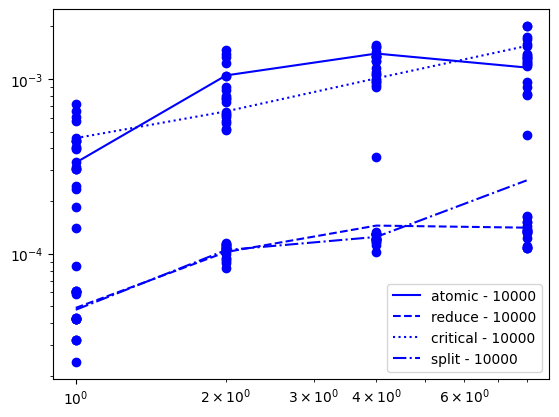

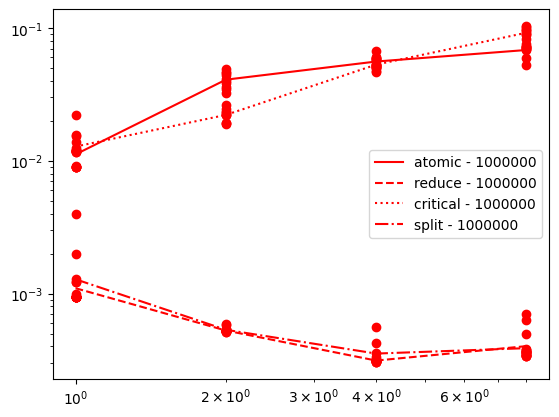

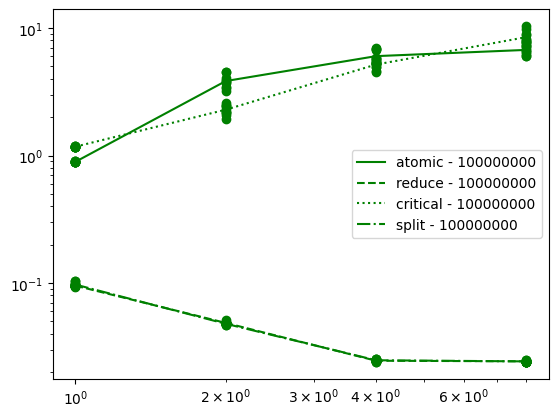

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt

import pandas as pd

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('pi_stats.csv',header=None,names=['version','nbcore','num_steps','runtime'],dtype={
                     'version': str,
                     'nbcore': int,
                     'num_steps' : int,
                     'runtime' : float
                 })

color_num_steps = {10000 : "blue", 1000000 : "red", 100000000 : "green"}
linestyle_version = {"atomic" : "solid", "reduce" : "dashed", "critical" : "dotted", "split" : "dashdot"}

for num_steps in color_num_steps:
    for version in linestyle_version:

        df_plot = df[(df['num_steps'] == num_steps) & (df['version'] == version)]
        mean_stats = df_plot.groupby(['num_steps','version','nbcore']).mean().reset_index()

        plt.plot(mean_stats['nbcore'], mean_stats['runtime'],linestyle=linestyle_version[version],color=color_num_steps[num_steps], label=version+" - "+str(num_steps))
        plt.yscale('log')
        plt.xscale('log')
        plt.scatter(df_plot['nbcore'], df_plot['runtime'],color=color_num_steps[num_steps])
    
    plt.legend()
    plt.show()


### Discussion

## Part 2 : Matrix-Vector operation

### Compilation

#### Cleaning

In [69]:
!rm tp_openmp_part_2_vector_sequential
!rm tp_openmp_part_2_vector_parallel
!rm tp_openmp_part_2_vector_simd

#### Compiling

In [70]:
!g++ -o tp_openmp_part_2_vector_sequential tp_openmp_part_2_vector_sequential.cpp -fopenmp -O3 -march=native
!g++ -o tp_openmp_part_2_vector_parallel tp_openmp_part_2_vector_parallel.cpp -fopenmp -O3 -march=native
!g++ -o tp_openmp_part_2_vector_simd tp_openmp_part_2_vector_simd.cpp -fopenmp -O3 -march=native

### Performance evaluation

In [75]:
import os
import subprocess
import csv
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

try:
    os.remove("vector_stats.csv")
except OSError:
    pass

# Creating the output csv file
with open("vector_stats.csv", "w") as stat_file:
    writer = csv.writer(stat_file)

nb_rows = [2, 4, 6, 8, 10, 12, 14, 16]
nb_columns = [1, 3, 5, 7, 9, 11, 13, 15]
nb_core = [1, 2, 4, 8]

for i in range(0,8):
    args = ("./tp_openmp_part_2_vector_sequential", "-N", str(nb_rows[i]), "-M", str(nb_columns[i]))
    popen = subprocess.Popen(args, stdout=subprocess.PIPE)
    popen.wait()

    for ncore in nb_core:
        args = ("./tp_openmp_part_2_vector_parallel", "-N", str(nb_rows[i]), "-M", str(nb_columns[i]), "-C", str(ncore))
        popen = subprocess.Popen(args, stdout=subprocess.PIPE)
        popen.wait()

        args = ("./tp_openmp_part_2_vector_simd", "-N", str(nb_rows[i]), "-M", str(nb_columns[i]), "-C", str(ncore))
        popen = subprocess.Popen(args, stdout=subprocess.PIPE)
        popen.wait()






### Performance Analysis